# ¿Cuál es la mejor tarifa?

Este proyecto educativo como analista para el operador de telecomunicaciones Megaline busca realizar un analisis de datos exhaustivo para analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Se realizará un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Se tienen los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. 

## Inicialización

In [358]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import math

## Cargar datos

In [359]:
# Carga los archivos de datos en diferentes DataFrames
calls= pd.read_csv('/datasets/megaline_calls.csv')
internet= pd.read_csv('/datasets/megaline_internet.csv')
messages= pd.read_csv('/datasets/megaline_messages.csv')
plans= pd.read_csv('/datasets/megaline_plans.csv')
users= pd.read_csv('/datasets/megaline_users.csv')

print(calls.head())
print(internet.head())
print(messages.head())
print(plans.head())
print(users.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0       

Los datos han sido correctamente cargados mediante 5 tablas almacenadas en 5 dataframes diferentes.

## Preparar los datos

## Tarifas

In [360]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [361]:
# Imprime una muestra de los datos para las tarifas
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Dentro de esta tabla tenemos la información de cada tarifa que ofrece la empresa, de acuerdo a las instrucciones que se nos han enviado, podemos obversar que se espera que las tarifas contengan la siguiente observación:

  <span style="color: blue">
    
**Surf**

Pago mensual: 20$ que incluye: 500 minutos al mes, 50 SMS y 15 GB de datos.

Pero si se exceden los límites del paquete:
   - 1 minuto: 3 centavos.
   - 1 SMS: 3 centavos.
   - 1 GB de datos: 10$.


 <span style="color: brown">

**Ultimate**

Pago mensual: 70$ que incluye: 3000 minutos al mes, 1000 SMS y 30 GB de datos.

Pero si se exceden los límites del paquete:
   - 1 minuto: 1 centavo.
   - 1 SMS: 1 centavo.
   - 1 GB de datos: 7$.
     
     
 <span style="color: black">    


## Corregir datos

Dentro de este apartado no tenemos nada que corregir de momento, no existe un error en los tipos de datos, no hay valores duplicados, tampoco valores nulos, es una tabla referencia que nos será útil en los proximos puntos del proyecto.

## Enriquecer los datos

Algo útil dentro de la realización de este proyecto es realizar una unión entre los planes que tenemos con la tabla de usuarios, de este modo podemos encontrar de forma más práctica la información.

In [362]:
plans_per_user = pd.merge(users, plans, left_on="plan", right_on="plan_name", how="left")
plans_per_user

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN,50,15360,500,20,10,0.03,0.03,surf
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN,1000,30720,3000,70,7,0.01,0.01,ultimate
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN,50,15360,500,20,10,0.03,0.03,surf


In [363]:
plans['gb_per_month_included'] = plans['mb_per_month_included']/1024 
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios/as

In [364]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [365]:
# Imprime una muestra de datos para usuarios
users.head(20)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


Dentro de nuestra tabla "users" contamos con siete columnas: id de usuario del cliente, primer nombre del cliente, apellido del cliente, edad del cliente, ciudad, fecha de registro, plan que esta utilizando y fecha de retorno o reactivación del plan, podemos observar que dentro de esta ultima columna "churn_date"; tenemos 466 valores ausentes lo cual se puede deber a que el cliente en cuestión todavía no ha reactivado su combo, a que se encuentra usando el plan por primera vez y aun no llega su primera reactivación o a que simplemente a decidido no usar más el servicio, de todas formas deberemos solucionar el tema de estos valores ausentes para poder trabajar con nuestros datos. Adicionalmente, me parece correcto transformar el tipo de dato de la columna "user_id" a un string.

### Corregir los datos

En primer lugar es importante saber si contamos con filas duplicadas.

In [366]:
users.duplicated().sum()

0

Al no ser así continuamos al tema de los valores ausentes:

In [367]:
users.isna().sum()



user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [368]:
users['churn_date'] = users['churn_date'].fillna(0)

In [369]:
users.isna().sum()

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

In [370]:
users['user_id'] = users['user_id'].astype(str)

Con esto hemos corregido la situación.

In [371]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    object
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  500 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.4+ KB


### Enriquecer los datos

Dentro de este apartado me parece sumamente útil convertir las fechas de nuestras dos columnas "reg_date" y "turn_date" a formato de datetime.

In [372]:
users["churn_date"]=pd.to_datetime(users["churn_date"], format='%Y-%m-%d')
users["reg_date"]=pd.to_datetime(users["reg_date"], format='%Y-%m-%d')

In [373]:
print(type(users["reg_date"]))
print(users["reg_date"])

<class 'pandas.core.series.Series'>
0     2018-12-24
1     2018-08-13
2     2018-10-21
3     2018-01-28
4     2018-05-23
         ...    
495   2018-09-04
496   2018-02-20
497   2018-12-10
498   2018-02-04
499   2018-05-06
Name: reg_date, Length: 500, dtype: datetime64[ns]


## Llamadas

In [374]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [375]:
# Imprime una muestra de datos para las llamadas
calls.head(20)


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


Dentro de esta tabla observamos cuatro columnas, el número de id de la llamada, el id del usuario que realiza la llamada, la fecha de la llamada y la duración que tuvo. En mi opinión, el la columna de user_id no debería constar como un tipo de dato entero sino como string, adicionalmente nos resultaría útil transforma la columna de la fecha a un formato de fecha.

### Corregir los datos

A continuación se realizan los cambios pertinentes dentro de nuestra tabla.

In [376]:
users.duplicated().sum()

0

Aquí también hemos comprobado primero no contar con la presencia de datos duplicados.

In [377]:
calls['user_id'] = calls['user_id'].astype(str)

In [378]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format='%Y-%m-%d')

print(type(calls["call_date"]))
print(calls["call_date"])


<class 'pandas.core.series.Series'>
0        2018-12-27
1        2018-12-27
2        2018-12-27
3        2018-12-28
4        2018-12-30
            ...    
137730   2018-11-21
137731   2018-10-20
137732   2018-09-21
137733   2018-10-10
137734   2018-12-29
Name: call_date, Length: 137735, dtype: datetime64[ns]


In [379]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.2+ MB


Con estas acciones hemos transformado nuestros datos de manera que sea para nosotros mas conveniente trabajar con ellos en lo posterior de este proyecto.

### Enriquecer los datos

En este punto, me parece util tener una tabla que nos indique las llamadas por cada usuario de nuestra muestra asi que realice un merge para obtener dicho resultado.

In [380]:
calls_per_user = pd.merge(calls, users, on='user_id', how='inner')
calls_per_user

,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_93,1000,2018-12-27,8.52,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
1,1000_145,1000,2018-12-27,13.66,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
2,1000_247,1000,2018-12-27,14.48,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
3,1000_309,1000,2018-12-28,5.76,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
4,1000_380,1000,2018-12-30,4.22,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
...,...,...,...,...,...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137731,1499_200,1499,2018-10-20,10.89,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137732,1499_201,1499,2018-09-21,8.12,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137733,1499_202,1499,2018-10-10,0.37,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01


In [381]:
calls_0_3=calls_per_user[calls_per_user["churn_date"] > calls_per_user["call_date"]]
calls_0_3

,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,churn_date
968,1006_0,1006,2018-12-12,0.00,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
969,1006_6,1006,2018-12-16,0.00,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
970,1006_22,1006,2018-12-17,12.09,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
971,1006_29,1006,2018-12-14,2.20,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
972,1006_36,1006,2018-11-29,2.72,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
...,...,...,...,...,...,...,...,...,...,...,...
135661,1491_632,1491,2018-07-15,0.00,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135662,1491_633,1491,2018-08-18,6.65,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135666,1491_637,1491,2018-05-23,11.28,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135667,1491_638,1491,2018-06-12,5.83,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18


In [382]:
calls_0_2=calls_per_user[calls_per_user["churn_date"] != pd.to_datetime('1970-01-01')]
calls_0_2

,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,churn_date
968,1006_0,1006,2018-12-12,0.00,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
969,1006_6,1006,2018-12-16,0.00,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
970,1006_22,1006,2018-12-17,12.09,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
971,1006_29,1006,2018-12-14,2.20,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
972,1006_36,1006,2018-11-29,2.72,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
...,...,...,...,...,...,...,...,...,...,...,...
135669,1491_640,1491,2018-05-15,3.80,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135670,1491_641,1491,2018-12-14,10.39,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135671,1491_642,1491,2018-10-08,6.91,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135672,1491_644,1491,2018-11-29,11.17,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18


In [383]:
calls_0_0=calls_per_user[(calls_per_user["churn_date"] != pd.to_datetime('1970-01-01')) & (calls_per_user["duration"] == 0)]
calls_0_0

,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,churn_date
968,1006_0,1006,2018-12-12,0.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
969,1006_6,1006,2018-12-16,0.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
3561,1012_1,1012,2018-12-19,0.0,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
3563,1012_3,1012,2018-12-07,0.0,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
3564,1012_4,1012,2018-11-15,0.0,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
...,...,...,...,...,...,...,...,...,...,...,...
135639,1491_603,1491,2018-10-14,0.0,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135640,1491_604,1491,2018-08-09,0.0,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135645,1491_609,1491,2018-06-05,0.0,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18
135660,1491_631,1491,2018-10-02,0.0,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18


In [384]:
calls_0=calls_per_user[calls_per_user["duration"] == 0]
calls_0

,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,churn_date
19,1001_4,1001,2018-12-05,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,1970-01-01
25,1001_13,1001,2018-12-24,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,1970-01-01
31,1001_30,1001,2018-10-17,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,1970-01-01
32,1001_31,1001,2018-11-03,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,1970-01-01
34,1001_35,1001,2018-12-21,0.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,1970-01-01
...,...,...,...,...,...,...,...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137715,1499_184,1499,2018-09-15,0.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137720,1499_189,1499,2018-12-27,0.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
137722,1499_191,1499,2018-12-24,0.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01


## Mensajes

In [385]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [386]:
# Imprime una muestra de datos para los mensajes
messages.head(20)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


Dentro de esta tabla observamos tres columnas, el número de id del mensaje enviado, el id del usuario que realiza el mensaje, y la fecha de envío del mensaje. En mi opinión, el la columna de user_id no debería constar como un tipo de dato entero sino como string, adicionalmente nos resultaría útil transforma la columna de la fecha a un formato datetime.

### Corregir los datos

En primer lugar, deseo descartar los duplicados:

In [387]:
messages.duplicated().sum()

0

Una vez que han sido descartados, podemos continuar con la transformación de nuestros datos.

In [388]:
messages['user_id'] = messages['user_id'].astype(str)

In [389]:
messages["message_date"] = pd.to_datetime(messages["message_date"], format='%Y-%m-%d')

print(type(messages["message_date"]))
print(messages["message_date"])


<class 'pandas.core.series.Series'>
0       2018-12-27
1       2018-12-31
2       2018-12-31
3       2018-12-27
4       2018-12-26
           ...    
76046   2018-12-24
76047   2018-12-24
76048   2018-12-31
76049   2018-12-24
76050   2018-12-23
Name: message_date, Length: 76051, dtype: datetime64[ns]


In [390]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Enriquecer los datos

De igual manera que con el tema de las llamadas, me parece util tener una tabla que nos indique los mensajes por cada usuario de nuestra muestra.

In [391]:
messages_per_user = pd.merge(messages, users, on='user_id', how='inner')
messages_per_user

,id,user_id,message_date,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_125,1000,2018-12-27,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
1,1000_160,1000,2018-12-31,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
2,1000_223,1000,2018-12-31,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
3,1000_251,1000,2018-12-27,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
4,1000_255,1000,2018-12-26,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
...,...,...,...,...,...,...,...,...,...,...
76046,1497_526,1497,2018-12-24,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,1970-01-01
76047,1497_536,1497,2018-12-24,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,1970-01-01
76048,1497_547,1497,2018-12-31,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,1970-01-01
76049,1497_558,1497,2018-12-24,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,1970-01-01


## Internet

In [392]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [393]:
# Imprime una muestra de datos para el tráfico de internet
internet.head(20)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


Dentro de esta tabla observamos 4 columnas, el número de id, el id del usuario en el tráfico de internet, la fecha de la sesión y los mb que han sido utilizados en esa navegación. En mi opinión, el la columna de user_id no debería constar como un tipo de dato entero sino como string, adicionalmente nos resultaría útil transforma la columna de la fecha a un formato datetime.

### Corregir los datos

In [394]:
internet.duplicated().sum()

0

In [395]:
internet['user_id'] = internet['user_id'].astype(str)

In [396]:
internet["session_date"] = pd.to_datetime(internet["session_date"], format='%Y-%m-%d')

print(type(internet["session_date"]))
print(internet["session_date"])

<class 'pandas.core.series.Series'>
0        2018-12-29
1        2018-12-31
2        2018-12-28
3        2018-12-26
4        2018-12-27
            ...    
104820   2018-10-20
104821   2018-12-30
104822   2018-09-22
104823   2018-12-07
104824   2018-12-24
Name: session_date, Length: 104825, dtype: datetime64[ns]


In [397]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


### Enriquecer los datos

Será útil para nosotros de igual manera obtener información sobre la navegación de cada cliente, para lo cual pocederemos a unir el dataframe de users con internet:

In [398]:
internet_per_user = pd.merge(internet, users, on='user_id', how='inner')
internet_per_user

,id,user_id,session_date,mb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000_13,1000,2018-12-29,89.86,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
1,1000_204,1000,2018-12-31,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
2,1000_379,1000,2018-12-28,660.40,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
3,1000_413,1000,2018-12-26,270.99,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
4,1000_442,1000,2018-12-27,880.22,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01
...,...,...,...,...,...,...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
104821,1499_216,1499,2018-12-30,304.72,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
104822,1499_217,1499,2018-09-22,292.75,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01
104823,1499_218,1499,2018-12-07,0.00,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,1970-01-01


## Estudiar las condiciones de las tarifas

In [399]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


Es importante comentar que en las próximas combinaciones de datos a realizar dentro del presente estudio, necesitaremos redondear hacia arriba los valores de nuestros gigabytes utilizados por cliente por lo que la previa transformación que realizamos de mb a gb y que consta en nuestra columna "gb_per_month_included" nos será de gran utilidad.

## Agregar datos por usuario

In [400]:
# Calcula la cantidad de llamadas por cada usuario al mes. Guarda el resultado.
calls['month'] = calls['call_date'].dt.month 
calls_per_user_per_month = calls.pivot_table(index=['user_id', 'month'],
                                values=['duration'],
                                aggfunc=['sum','count']).reset_index()
calls_per_user_per_month

,user_id,month,sum,count
,,,duration,duration
0,1000,12,116.83,16
1,1001,8,171.14,27
2,1001,9,297.69,49
3,1001,10,374.11,65
4,1001,11,404.59,64
...,...,...,...,...
2253,1498,12,324.77,39
2254,1499,9,330.37,41
2255,1499,10,363.28,53


In [442]:
# Calcula la cantidad de minutos de llamadas realizadas por cada usuario al mes. Guarda el resultado.
minutes_per_month = calls.groupby(['user_id', 'month']).sum().reset_index()
minutes_per_month = minutes_per_month.rename(columns={'duration': 'minutes_per_month'})
minutes_per_month.head(20)

,user_id,month,minutes_per_month
0,1000,2018-12,116.83
1,1001,2018-08,171.14
2,1001,2018-09,297.69
3,1001,2018-10,374.11
4,1001,2018-11,404.59
5,1001,2018-12,392.93
6,1002,2018-10,54.13
7,1002,2018-11,359.76
8,1002,2018-12,363.24
9,1003,2018-12,1041.00


In [404]:
minutes_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            2258 non-null   object
 1   month              2258 non-null   int64 
 2   minutes_per_month  2258 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.0+ KB


In [410]:
minutes_per_month["minutes_per_month"]= minutes_per_month["minutes_per_month"].apply(lambda x: math.ceil(x))
minutes_per_month

,user_id,month,minutes_per_month
0,1000,12,117
1,1001,8,172
2,1001,9,298
3,1001,10,375
4,1001,11,405
...,...,...,...
2253,1498,12,325
2254,1499,9,331
2255,1499,10,364
2256,1499,11,289


Con esto hemos rendondeado los valores de minutos al inmedianto superior.

In [414]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages['month'] = messages['message_date'].dt.month   

messages_month = messages.groupby(['user_id', 'month']).size().reset_index(name='messages_per_user_per_month')

messages_month.head(20)


,user_id,month,messages_per_user_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15
7,1002,11,32
8,1002,12,41
9,1003,12,50


In [415]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet['month'] = internet['session_date'].dt.month   

volume_per_month = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index(name='volume_per_user_per_month')

volume_per_month.head(20)

,user_id,month,volume_per_user_per_month
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
5,1001,12,19369.18
6,1002,10,6552.01
7,1002,11,19345.08
8,1002,12,14396.24
9,1003,12,27044.14


In [416]:
volume_per_month["volume_per_user_per_month"]= volume_per_month["volume_per_user_per_month"].apply(lambda x: math.ceil(x))
volume_per_month

,user_id,month,volume_per_user_per_month
0,1000,12,1902
1,1001,8,6920
2,1001,9,13315
3,1001,10,22331
4,1001,11,18505
...,...,...,...
2272,1498,12,23138
2273,1499,9,12985
2274,1499,10,19493
2275,1499,11,16814


Con esto tambien hemos redondeado al inmediato superior el tráfico en internet.

A continuación juntaré los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.

In [417]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merge1=pd.merge(calls_per_user_per_month, minutes_per_month, on=['user_id', 'month'], how='outer')
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 2257
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            2258 non-null   object 
 1   month              2258 non-null   int64  
 2   (user_id, )        2258 non-null   object 
 3   (month, )          2258 non-null   int64  
 4   (sum, duration)    2258 non-null   float64
 5   (count, duration)  2258 non-null   int64  
 6   minutes_per_month  2258 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 141.1+ KB


/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [418]:
merge2=pd.merge(merge1, messages_month, on=['user_id', 'month'], how='outer')
merge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291 entries, 0 to 2290
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      2291 non-null   object 
 1   month                        2291 non-null   int64  
 2   (user_id, )                  2258 non-null   object 
 3   (month, )                    2258 non-null   float64
 4   (sum, duration)              2258 non-null   float64
 5   (count, duration)            2258 non-null   float64
 6   minutes_per_month            2258 non-null   float64
 7   messages_per_user_per_month  1806 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 161.1+ KB


In [419]:
merge3=pd.merge(merge2, volume_per_month, on=['user_id', 'month'], how='outer') 
merge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      2293 non-null   object 
 1   month                        2293 non-null   int64  
 2   (user_id, )                  2258 non-null   object 
 3   (month, )                    2258 non-null   float64
 4   (sum, duration)              2258 non-null   float64
 5   (count, duration)            2258 non-null   float64
 6   minutes_per_month            2258 non-null   float64
 7   messages_per_user_per_month  1806 non-null   float64
 8   volume_per_user_per_month    2277 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 179.1+ KB


In [420]:
# Añade la información de la tarifa
fusion = pd.merge(merge3, users, on=['user_id'], how='outer')
fusionfinal = pd.merge(fusion, plans, left_on='plan', right_on='plan_name', how='right')
fusionfinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      2303 non-null   object        
 1   month                        2293 non-null   float64       
 2   (user_id, )                  2258 non-null   object        
 3   (month, )                    2258 non-null   float64       
 4   (sum, duration)              2258 non-null   float64       
 5   (count, duration)            2258 non-null   float64       
 6   minutes_per_month            2258 non-null   float64       
 7   messages_per_user_per_month  1806 non-null   float64       
 8   volume_per_user_per_month    2277 non-null   float64       
 9   first_name                   2303 non-null   object        
 10  last_name                    2303 non-null   object        
 11  age                          2303 non-null 

In [421]:
fusionfinal.isna().sum()
fusionfinal.fillna(0, inplace=True)

In [422]:
fusionfinal

,user_id,month,"(user_id, )","(month, )","(sum, duration)","(count, duration)",minutes_per_month,messages_per_user_per_month,volume_per_user_per_month,first_name,...,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,1001,8.0,1001,8.0,171.14,27.0,172.0,30.0,6920.0,Mickey,...,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1001,9.0,1001,9.0,297.69,49.0,298.0,44.0,13315.0,Mickey,...,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0
2,1001,10.0,1001,10.0,374.11,65.0,375.0,53.0,22331.0,Mickey,...,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0
3,1001,11.0,1001,11.0,404.59,64.0,405.0,36.0,18505.0,Mickey,...,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0
4,1001,12.0,1001,12.0,392.93,56.0,393.0,44.0,19370.0,Mickey,...,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1108,12.0,0,0.0,0.00,0.0,0.0,0.0,234.0,Porfirio,...,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
2299,1025,0.0,0,0.0,0.00,0.0,0.0,0.0,0.0,Jess,...,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
2300,1269,0.0,0,0.0,0.00,0.0,0.0,0.0,0.0,Irving,...,2018-12-15,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
2301,1275,0.0,0,0.0,0.00,0.0,0.0,0.0,0.0,Elvie,...,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


In [423]:
# Calcula el ingreso mensual para cada usuario
fusionfinal['excess_minutes'] = (fusionfinal['minutes_per_month'] - fusionfinal['minutes_included']).clip(lower=0)
fusionfinal['excess_messages'] = (fusionfinal['messages_per_user_per_month'] - fusionfinal['messages_included']).clip(lower=0)
fusionfinal['excess_mb'] = (fusionfinal['volume_per_user_per_month'] - fusionfinal['mb_per_month_included']).clip(lower=0)

fusionfinal['extra_minutes_cost'] = fusionfinal['excess_minutes'] * fusionfinal['usd_per_minute']
fusionfinal['extra_messages_cost'] = fusionfinal['excess_messages'] * fusionfinal['usd_per_message']
fusionfinal['extra_mb_cost'] = fusionfinal['excess_mb'] / 1000 * fusionfinal['usd_per_gb']  # Convertimos MB a GB para poder sacar el costo de esta tarifa

fusionfinal['total_monthly_revenue'] = fusionfinal['usd_monthly_pay'] + fusionfinal['extra_minutes_cost'] + fusionfinal['extra_messages_cost'] + fusionfinal['extra_mb_cost']


incomes = fusionfinal[['user_id', 'month', 'total_monthly_revenue', 'plan']]
incomes



,user_id,month,total_monthly_revenue,plan
0,1001,8.0,20.00,surf
1,1001,9.0,20.00,surf
2,1001,10.0,89.80,surf
3,1001,11.0,51.45,surf
4,1001,12.0,60.10,surf
...,...,...,...,...
2298,1108,12.0,70.00,ultimate
2299,1025,0.0,70.00,ultimate
2300,1269,0.0,70.00,ultimate
2301,1275,0.0,70.00,ultimate


## Estudia el comportamiento de usuario

### Llamadas

In [424]:
calls.head


<bound method NDFrame.head of               id user_id  call_date  duration  month
0        1000_93    1000 2018-12-27      8.52     12
1       1000_145    1000 2018-12-27     13.66     12
2       1000_247    1000 2018-12-27     14.48     12
3       1000_309    1000 2018-12-28      5.76     12
4       1000_380    1000 2018-12-30      4.22     12
...          ...     ...        ...       ...    ...
137730  1499_199    1499 2018-11-21      8.72     11
137731  1499_200    1499 2018-10-20     10.89     10
137732  1499_201    1499 2018-09-21      8.12      9
137733  1499_202    1499 2018-10-10      0.37     10
137734  1499_203    1499 2018-12-29     13.86     12

[137735 rows x 5 columns]>

In [425]:

combined_calls_plan = pd.merge(calls_per_user, plans, left_on='plan', right_on='plan_name', how='outer')
combined_calls_plan['call_date'] = pd.to_datetime(combined_calls_plan['call_date'])
combined_calls_plan['month'] = combined_calls_plan['call_date'].dt.month
combined_calls_plan


,id,user_id,call_date,duration,first_name,last_name,age,city,reg_date,plan,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,month
0,1000_93,1000,2018-12-27,8.52,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
1,1000_145,1000,2018-12-27,13.66,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
2,1000_247,1000,2018-12-27,14.48,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
3,1000_309,1000,2018-12-28,5.76,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
4,1000_380,1000,2018-12-30,4.22,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,11
137731,1499_200,1499,2018-10-20,10.89,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,10
137732,1499_201,1499,2018-09-21,8.12,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,9
137733,1499_202,1499,2018-10-10,0.37,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,10


In [426]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

average_call_duration = combined_calls_plan.groupby(['month','plan_name'])['duration'].mean().reset_index()

average_call_duration_total = average_call_duration.sort_values(by=['month'])
pivoted_data = average_call_duration.pivot(index='month', columns='plan_name', values='duration')
pivoted_data.head(12)

plan_name,surf,ultimate
month,,
1,6.428000,6.541518
2,6.906175,6.517230
3,6.696919,6.210906
4,6.799918,6.659990
5,6.769200,6.662443
6,6.846812,6.705188
7,6.721710,6.879085
8,6.726164,6.613484
9,6.728684,6.770040


Acontinuación ilustraré mi resultado con el siguiente gráfico de barras:

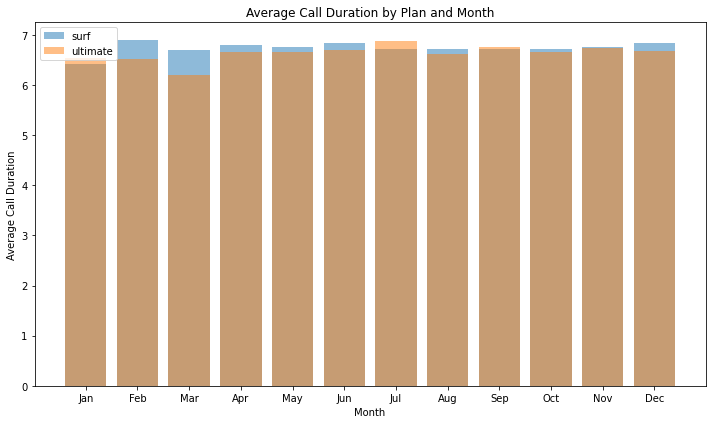

In [427]:
plt.figure(figsize=(10, 6))
for plan_name, group in average_call_duration_total.groupby('plan_name'):
    plt.bar(group['month'], group['duration'], label=plan_name, alpha=0.5)
plt.xlabel('Month')
plt.ylabel('Average Call Duration')
plt.title('Average Call Duration by Plan and Month')
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

In [428]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
calls['call_date'] = pd.to_datetime(calls['call_date'])

calls['month'] = calls['call_date'].dt.to_period('M')

user_monthly_minutes = combined_calls_plan.groupby(['user_id', 'plan_name', 'month'])['duration'].sum().reset_index()


average_minutes_by_plan = user_monthly_minutes.groupby(['plan_name', 'month'])['duration'].mean().reset_index()

average_minutes_by_plan = average_minutes_by_plan.sort_values(by=['plan_name', 'month'])

print(average_minutes_by_plan)

   plan_name  month    duration
0       surf      1  192.840000
1       surf      2  280.851111
2       surf      3  310.970000
3       surf      4  332.380000
4       surf      5  387.108000
5       surf      6  411.450625
6       surf      7  428.060917
7       surf      8  394.474717
8       surf      9  397.133298
9       surf     10  414.435733
10      surf     11  408.255415
11      surf     12  457.547074
12  ultimate      1  183.162500
13  ultimate      2  443.171667
14  ultimate      3  285.701667
15  ultimate      4  316.508095
16  ultimate      5  383.664828
17  ultimate      6  365.358222
18  ultimate      7  403.767288
19  ultimate      8  397.274789
20  ultimate      9  413.287326
21  ultimate     10  429.217238
22  ultimate     11  423.814683
23  ultimate     12  438.824832


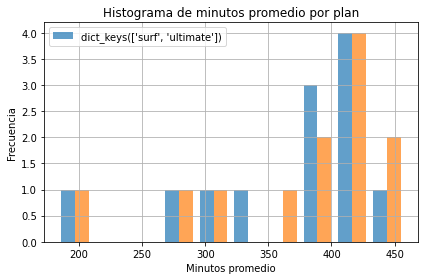

In [429]:
data = {}
for plan_name in average_minutes_by_plan['plan_name'].unique():
    plan_data = average_minutes_by_plan[average_minutes_by_plan['plan_name'] == plan_name]
    data[plan_name] = plan_data['duration']

plt.hist(data.values(), bins=10, alpha=0.7, label=data.keys())

plt.xlabel('Minutos promedio')
plt.ylabel('Frecuencia')
plt.title('Histograma de minutos promedio por plan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [430]:
# Calcula la media y la varianza de la duración mensual de llamadas.

calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.to_period('M')
monthly_stats = combined_calls_plan.groupby(['month','plan_name'])['duration'].agg(['mean', 'var']).reset_index()
monthly_stats

,month,plan_name,mean,var
0,1,surf,6.428000,28.208311
1,1,ultimate,6.541518,35.442188
2,2,surf,6.906175,35.218169
3,2,ultimate,6.517230,33.688628
4,3,surf,6.696919,32.393177
5,3,ultimate,6.210906,32.882171
6,4,surf,6.799918,33.406473
7,4,ultimate,6.659990,32.071262
8,5,surf,6.769200,34.617366
9,5,ultimate,6.662443,34.371065


<Figure size 720x648 with 0 Axes>

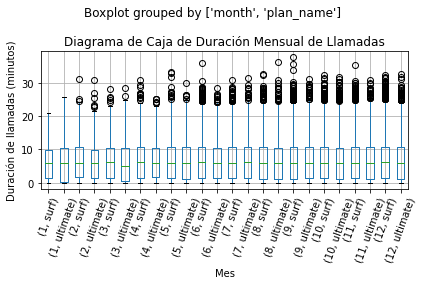

In [431]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.figure(figsize=(10, 9))
combined_calls_plan.boxplot(column='duration', by=(['month','plan_name']), grid=False) 
plt.title('Diagrama de Caja de Duración Mensual de Llamadas')
plt.xlabel('Mes')
plt.ylabel('Duración de llamadas (minutos)')
plt.grid(True)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

En Surf se tienen mas minutos de llamadas como pudimos observar en el gráfico de barras, específicamente hay un aumento en los meses de febrero, marzo, abril, mayo y junio, agosto, octubre y diciembre, en el mes de julio al contrario se ve que los usuarios que utilizan el plan ultimate usan mas minutos en sus llamadas, por otro lado, se tienen mayores valores atípicos conforme al diagrama de Caja que hemos realizado respecto al plan Surf.

### Mensajes

In [432]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
combined_messages_plan = pd.merge(messages_per_user, plans, left_on='plan', right_on='plan_name', how='outer')
combined_messages_plan['message_date'] = pd.to_datetime(combined_messages_plan['message_date'])
combined_messages_plan['month'] = combined_messages_plan['message_date'].dt.month
combined_messages_plan


,id,user_id,message_date,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,month
0,1000_125,1000,2018-12-27,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
1,1000_160,1000,2018-12-31,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
2,1000_223,1000,2018-12-31,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
3,1000_251,1000,2018-12-27,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
4,1000_255,1000,2018-12-26,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,1970-01-01,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76046,1496_60,1496,2018-11-19,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0,11
76047,1496_61,1496,2018-09-14,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0,9
76048,1496_62,1496,2018-11-17,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0,11
76049,1496_63,1496,2018-10-18,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,1970-01-01,50,15360,500,20,10,0.03,0.03,surf,15.0,10


In [433]:
messages_per_mounth = combined_messages_plan.groupby(['month','plan_name']).count().reset_index()

messages_per_mounth_total = messages_per_mounth.sort_values(by=['month'])
pivoted_data1 = messages_per_mounth_total.pivot(index='month', columns='plan_name')
pivoted_data1['user_id'].head(12)

plan_name,surf,ultimate
month,,
1,21,62
2,108,151
3,351,243
4,870,463
5,1849,931
6,2454,1379
7,3271,1937
8,4662,2732
9,5968,3259


Respecto a este apartado, podemosobservar que los clientes que utilizan el plan Surf tambien envían mas mensajes en comparación al plan ultimate, claro que esto varia del mes pero claramente en el sentido anual se enviaron más mensajes utilizando el plan Surf que utilizando el plan Ultimate.

### Internet

In [434]:
#Compara la cantidad de trafico de internet consumido por usuarios por plan
combined_internet_plan = pd.merge(internet_per_user, plans, left_on='plan', right_on='plan_name', how='outer')
combined_internet_plan['session_date'] = pd.to_datetime(combined_internet_plan['session_date'])
combined_internet_plan['month'] = combined_internet_plan['session_date'].dt.month
combined_internet_plan

,id,user_id,session_date,mb_used,first_name,last_name,age,city,reg_date,plan,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,month
0,1000_13,1000,2018-12-29,89.86,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
1,1000_204,1000,2018-12-31,0.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
2,1000_379,1000,2018-12-28,660.40,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
3,1000_413,1000,2018-12-26,270.99,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
4,1000_442,1000,2018-12-27,880.22,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,...,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,10
104821,1499_216,1499,2018-12-30,304.72,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,12
104822,1499_217,1499,2018-09-22,292.75,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,9
104823,1499_218,1499,2018-12-07,0.00,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,...,50,15360,500,20,10,0.03,0.03,surf,15.0,12


In [435]:
data_internet_stats = combined_internet_plan.groupby('plan_name')['mb_used'].agg(['sum', 'mean']).reset_index()

data_internet_stats.rename(columns={'sum': 'Total MB Used', 'mean': 'Average MB per User'}, inplace=True)

data_internet_stats = data_internet_stats.sort_values(by='Total MB Used', ascending=False)

data_internet_stats

,plan_name,Total MB Used,Average MB per User
0,surf,26046179.93,363.844606
1,ultimate,12394583.78,372.892800


Efectivamente, como hemos visto en los temas anteriores respecto a las llamadas y mensajes, sucede lo mismo con las megas de navegación de internet, el plan Surf resulta tener un mayor trafico de internet, esto puede deberse a que es más común que las personas opten por un plan más económico y accesible.

## Ingreso

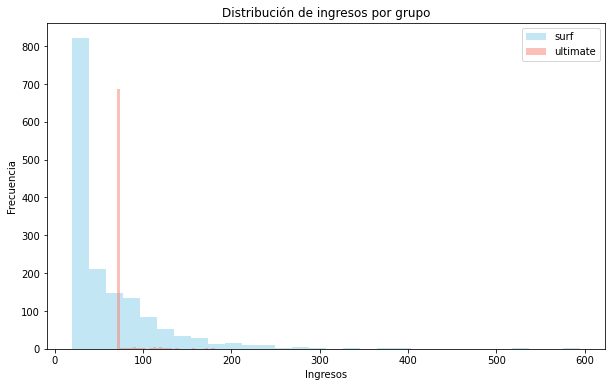

In [436]:
ingresos_grupo_surf = fusionfinal[fusionfinal['plan'] == 'surf']['total_monthly_revenue']
ingresos_grupo_ultimate = fusionfinal[fusionfinal['plan'] == 'ultimate']['total_monthly_revenue']
plt.figure(figsize=(10, 6))

plt.hist(ingresos_grupo_surf, bins=30, alpha=0.5, color='skyblue', label='surf')
plt.hist(ingresos_grupo_ultimate, bins=30, alpha=0.5, color='salmon', label='ultimate')

plt.title('Distribución de ingresos por grupo')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [437]:
estadisticas_surf = ingresos_grupo_surf.describe()
estadisticas_ultimate = ingresos_grupo_ultimate.describe()

total_ingresos_surf = ingresos_grupo_surf.sum()
total_ingresos_ultimate = ingresos_grupo_ultimate.sum()

print("Estadísticas de ingresos para el plan 'Surf':")
print(estadisticas_surf)
print("Total de ingresos para el plan 'Surf':", total_ingresos_surf)

print("\nEstadísticas de ingresos para el plan 'Ultimate':")
print(estadisticas_ultimate)
print("Total de ingresos para el plan 'Ultimate':", total_ingresos_ultimate)


Estadísticas de ingresos para el plan 'Surf':
count    1579.000000
mean       58.011058
std        54.951772
min        20.000000
25%        20.000000
50%        36.710000
75%        78.150000
max       594.380000
Name: total_monthly_revenue, dtype: float64
Total de ingresos para el plan 'Surf': 91599.45999999999

Estadísticas de ingresos para el plan 'Ultimate':
count    724.000000
mean      72.155110
std       10.998678
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      181.132000
Name: total_monthly_revenue, dtype: float64
Total de ingresos para el plan 'Ultimate': 52240.3


In [438]:
ingresos_totales_surf = ingresos_grupo_surf.sum()
ingresos_totales_ultimate = ingresos_grupo_ultimate.sum()

if ingresos_totales_surf > ingresos_totales_ultimate:
    print("El plan 'surf' genera más ingresos.")
elif ingresos_totales_surf < ingresos_totales_ultimate:
    print("El plan 'ultimate' genera más ingresos.")
else:
    print("Ambos planes generan la misma cantidad de ingresos.")

El plan 'surf' genera más ingresos.


En conclusión podemos ver que los ingresos para el plan Surf son superiores a los ingresos del plan Ultimate a pesar de todo lo analizado anteriormente, esto puede deberse a que el plan Surf es mucho más económico pero el ser consumido de manera masiva genera mayores ingresos que Ultimate por ser un plan de mayor popularidad.

## Prueba las hipótesis estadísticas

In [439]:
#El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
alpha = 0.05  

ingresos_grupo_surf = fusionfinal[fusionfinal['plan'] == 'surf']['total_monthly_revenue']
ingresos_grupo_ultimate = fusionfinal[fusionfinal['plan'] == 'ultimate']['total_monthly_revenue']

results = st.ttest_ind(ingresos_grupo_surf, ingresos_grupo_ultimate, equal_var=False)

print('Valor p:', results.pvalue)

if results.pvalue < alpha: 
    print("Rechazamos la hipótesis")
else:
    print("No podemos rechazar la hipótesis nula")

Valor p: 3.596387944508941e-22
Rechazamos la hipótesis


In [440]:
#El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.
alpha = 0.05  

ingresos_area_nynj = fusionfinal[fusionfinal['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_monthly_revenue']
ingresos_otras_regiones = fusionfinal[fusionfinal['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_monthly_revenue']


results = st.ttest_ind(ingresos_area_nynj, ingresos_otras_regiones, equal_var=False)

print('Valor p:', results.pvalue)

if results.pvalue < alpha: 
    print("Rechazamos la hipótesis nula: ")
else:
    print("No podemos rechazar la hipótesis nula")


Valor p: 0.026554728857055926
Rechazamos la hipótesis nula: 


## Conclusión general

Este proyecto se baso en información de la empresa MEGALINE, esta empresa dentro de nuestro estudio quiso analizar mediante 5 base de datos distribuidas en dataframes diferentes (users, calls, messages, internet, plans), información respecto a dos planes que se ofertan a los usuarios, el plan Surf y el plan Ultimate, para responder a sus preguntas debimos realizar lo siguiente:
1. Importar las librerias que nos serian utiles para este estudio.
2. Cargar los datos mediante 5 dataframes diferentes a fin de facilitar nuestra exploracion de datos.
3. Realizar un preprocesamiento de datos y corregir distintos errores que se presentaron.
4. Empezar a procesar los datos, creacion de fusiones entre dataframes, encontrando conjuntos de datos en especifico mediante la agrupación, tambien debimos comparar en varias ocasiones a los planes Surf y Ultimate, asi como realizar graficas ilustrativas que nos ayuden a comprender mejor los datos.
5. Debimos analizar valores generados por ambos grupos y realizar dos pruebas de hipótesis.

En conclusión este proyecto se enfoco en determinar el consumo en ambos planes, determinar los ingresos que cada uno de ellos generaba asi como el consumo para distintas areas tales como minutos de llamadas, llamadas, mensajes que se enviaban y trafico de internet, ademas de comparar a ambos planes posteriomente y sacar conclusiones en base a esas comparaciones.